In [1]:
# Import dependecies 
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
import scipy.stats as st 
from scipy.stats import linregress
import yfinance as yf
import numpy as np
import seaborn as sns

from config import eia_api_key

# Energy Information Administration (Oil Consumption)
- "Approximately represents consumption of petroleum products because it measures the disappearance of these products from primary sources, i.e., refineries, natural gas processing plants, blending plants, pipelines, and bulk terminals. In general, product supplied of each product in any given period is computed as follows: field production, plus renewable fuels and oxygenate plant net production, plus refinery and blender net production, plus imports, plus net receipts, plus adjustments, minus stock change, minus refinery and blender net inputs, minus exports."
<br>

Source: Energy Information Administration,  March 2023

In [2]:
# set the base url
eia_base_url = "https://api.eia.gov/v2"

# set the endpoint
endpoint = "/petroleum/sum/snd/data/"

# set the params as provided by the EIA 
params = {
    "api_key": eia_api_key,
    "frequency": "monthly",
    "data[0]": "value",
    "facets[series][]": "MTTUPUS1",
    "start": "2019-01",
    "end": "2023-01",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# pretty print the json 
response = requests.get(eia_base_url + endpoint, params=params).json()
print(json.dumps(response, indent=4, sort_keys=True))


{
    "apiVersion": "2.1.4",
    "request": {
        "command": "/v2/petroleum/sum/snd/data/",
        "params": {
            "data": [
                "value"
            ],
            "end": "2023-01",
            "facets": {
                "series": [
                    "MTTUPUS1"
                ]
            },
            "frequency": "monthly",
            "length": 5000,
            "offset": 0,
            "sort": [
                {
                    "column": "period",
                    "direction": "desc"
                }
            ],
            "start": "2019-01"
        }
    },
    "response": {
        "data": [
            {
                "area-name": "U.S.",
                "duoarea": "NUS",
                "period": "2022-12",
                "process": "VPP",
                "process-name": "Product Supplied",
                "product": "EP00",
                "product-name": "Crude Oil and Petroleum Products",
                "series": "MTTUPUS1",
  

In [3]:
# accessing the values 
response_data = response["response"]["data"]

# using a list comphrension to create a list of dictionaries for the value and period
extracted_data = [{'value': data['value'], 'period': data['period']} for data in response_data]

# Create a DataFrame from the formatted data
df = pd.DataFrame(extracted_data)

# converting the strings of the period column to datetime to separate it by the year and month
df['period'] = pd.to_datetime(df['period'])
df['Year'] = df['period'].dt.year
df['month'] = df['period'].dt.month

# pivot the original df so that the index is the year, the columns are the months, and the values are 
# in the corresponding row and column

oil_df = df.pivot(index="Year", columns="month", values="value")

month_names = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]
oil_df.columns = [month_names[column - 1] for column in oil_df.columns]
print("* Total U.S. Product Supplied of Crude Oil and Petroleum Products (Thousand Barrels)")
oil_df.style.highlight_min(color='salmon').highlight_max(color='limegreen')

* Total U.S. Product Supplied of Crude Oil and Petroleum Products (Thousand Barrels)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,639064,567948,625463,609978,632000,619619,642772,655895,607454,642134,622085,633729
2020,617935,583835,572348,436455,498424,527342,569813,575294,552445,577023,562276,582852
2021,583245,495575,593096,592311,621542,617576,625327,637750,604157,631692,617179,640357
2022,611662,572198,635868,598721,622381,623159,630696,638632,614099,632856,617792,604227


# EIA (Natural Gas Consumption)
- THIS CAN BE OMITTED

In [4]:
eia_base_url = "https://api.eia.gov/v2"
endpoint = "/natural-gas/sum/snd/data/"
params = {
    "api_key": eia_api_key,
    "frequency": "monthly",
    "data[0]": "value",
    "facets[series][]": "N9140US2",
    "start": "2019-01",
    "end": "2023-01",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

response = requests.get(eia_base_url + endpoint, params=params).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "apiVersion": "2.1.4",
    "request": {
        "command": "/v2/natural-gas/sum/snd/data/",
        "params": {
            "api_key": "ngmRW4yA8JFQePWB6vOYe3hMlee8YVonfRfGoC3h",
            "data": [
                "value"
            ],
            "end": "2023-01",
            "facets": {
                "series": [
                    "N9140US2"
                ]
            },
            "frequency": "monthly",
            "length": 5000,
            "offset": 0,
            "sort": [
                {
                    "column": "period",
                    "direction": "desc"
                }
            ],
            "start": "2019-01"
        }
    },
    "response": {
        "data": [
            {
                "area-name": "U.S.",
                "duoarea": "NUS",
                "period": "2022-12",
                "process": "VC0",
                "process-name": "Total Consumption",
                "product": "EPG0",
                "product-name": "Natur

In [5]:
response_data2 = response['response']['data']
extracted_data2 = [{'value': data['value'], 'period': data['period']} for data in response_data2]
df2 = pd.DataFrame(extracted_data2) 
df2['period'] = pd.to_datetime(df2['period'])
df2['Year'] = df2['period'].dt.year
df2['month'] = df2['period'].dt.month
gas_df = df2.pivot(index='Year', columns='month', values='value')

month_names = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

gas_df.columns = [month_names[column - 1] for column in gas_df.columns]
print('* U.S. Natural Gas Total Consumption (Million Cubic Feet)')
gas_df.style.highlight_min(color='salmon').highlight_max(color='limegreen')

* U.S. Natural Gas Total Consumption (Million Cubic Feet)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,3424302,3019120,2927812,2212386,2133985,2119341,2393904,2433924,2206252,2306544,2783754,3170717
2020,3320552,3058519,2721990,2256849,2072161,2127914,2464089,2399535,2151180,2315892,2441945,3182826
2021,3343928,3099220,2649393,2265143,2117403,2238388,2412185,2433799,2142309,2262597,2693262,3007324
2022,3591691,3061123,2781491,2367455,2242380,2317957,2582948,2559505,2288505,2365973,2772945,3381890


# Stock Price Data 

In [6]:
# Function to create a dataframe with the averages of stock by month and year.
def ticker_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data = pd.DataFrame(data['Close'])
    data.index = pd.to_datetime(data.index)
    data['Year'] = data.index.year
    data['Month'] = data.index.month
    grouped_data = data.groupby(['Year', 'Month']).mean()
    return grouped_data

# Function that pivots the table so that the index is 'Year', columns are 'Month', and the values of the averages
def pivot_stock_data(df, ticker):
    pivot_df = df.pivot_table(index='Year', columns='Month', values='Close')
    months_list = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]
    pivot_df.columns = [months_list[column - 1] for column in pivot_df.columns]
    return pivot_df

In [7]:
# List of tickers
ticker_list = ['XOM', 'CVX', 'COP', 'MRO', 'SHEL', 'BP']

# Setting up start and end dates
start_date = '2019-01-01'
end_date = '2023-01-01'

# Although you can loop through the ticker_list, it will be best to print according to the tickers we want.

exxon_data = ticker_stock_data('XOM', start_date, end_date)
exxon_df = pivot_stock_data(exxon_data, 'XOM')

# Display of ExxonMobil data
print('ExxonMobil Monthly Stock Prices (2019-2022)')
exxon_df.style.highlight_min(color='salmon').highlight_max(color='limegreen')

[*********************100%***********************]  1 of 1 completed
ExxonMobil Monthly Stock Prices (2019-2022)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,71.614286,76.770526,80.396667,81.586666,75.487272,75.143499,75.880909,69.426363,71.548500,68.404783,69.685999,69.456667
2020,67.821905,58.640000,40.225455,42.293334,44.491000,47.617727,43.419091,42.346190,36.752381,33.678182,36.850500,41.892727
2021,46.542105,51.364210,58.170870,56.469048,59.967000,62.554546,59.127619,56.035455,55.850952,62.613333,63.666190,61.277273
2022,71.338000,78.886316,82.338260,85.335500,91.012381,94.013333,87.475500,93.799999,92.194762,102.352857,112.149047,106.928095


In [8]:
chevron_data = ticker_stock_data('CVX', start_date, end_date)
chevron_df = pivot_stock_data(chevron_data, 'CVX')

# Display of Chevron data
print('Chevron Monthly Stock Prices (2019-2022)')
chevron_df.style.highlight_min(color='salmon').highlight_max(color='limegreen')

[*********************100%***********************]  1 of 1 completed
Chevron Monthly Stock Prices (2019-2022)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,112.240953,119.072106,123.687619,122.136190,118.999544,121.746001,124.613636,118.484090,121.227000,115.634348,119.509999,118.495715
2020,115.090000,106.702631,76.464090,83.821905,91.578501,93.112273,87.845000,87.155714,77.131429,71.922728,82.833000,88.309092
2021,90.783684,93.881579,106.424783,103.231905,106.384500,107.047273,101.575238,99.478636,98.188571,109.554762,114.705715,116.379090
2022,127.539501,136.176315,163.189131,165.205999,168.649048,162.044286,144.389000,158.476087,153.706666,165.943808,183.159525,174.412857


In [16]:
conoco_data = ticker_stock_data('COP', start_date, end_date)
conoco_df = pivot_stock_data(conoco_data, 'CVX')

# Display of ConocoPhillips data
print('ConocoPhillips Monthly Stock Prices (2019-2022)')
conoco_df.style.highlight_min(color='salmon').highlight_max(color='limegreen')

[*********************100%***********************]  1 of 1 completed
ConocoPhillips Monthly Stock Prices (2019-2022)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,65.661429,68.818947,67.492380,65.632381,61.389091,59.600500,60.143636,53.111818,57.533000,55.242174,58.748500,62.742857
2020,63.894762,56.654737,33.454091,34.987143,42.095000,44.155909,40.196818,38.975714,34.390000,32.716364,36.555500,41.272273
2021,43.705789,47.623157,55.269131,51.362381,55.630000,60.003182,57.810953,55.428182,59.989047,73.996666,72.962857,71.685454
2022,83.636500,91.120527,99.920435,98.540001,104.878571,105.465238,87.880000,102.005217,108.582380,120.298572,129.297620,115.060000


In [10]:
marathon_data = ticker_stock_data('MRO', start_date, end_date)
marathon_df = pivot_stock_data(marathon_data, 'CVX')

# Display of Marathon Oil Corp data
print('Marathon Oil Corp Monthly Stock Prices (2019-2022)')
marathon_df.style.highlight_min(color='salmon').highlight_max(color='limegreen')

[*********************100%***********************]  1 of 1 completed
Marathon Oil Corp Monthly Stock Prices (2019-2022)


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2019,15.712857,16.258947,17.039524,17.565238,15.145000,13.604500,13.700455,12.399091,12.671500,11.628696,12.050000,12.932381
2020,12.820952,10.496842,4.669091,4.346667,5.757500,6.447273,5.624091,5.678571,4.536190,4.148636,5.258500,6.701818
2021,7.854210,9.276316,11.443478,10.933333,11.687000,13.541818,12.344762,11.644091,12.196667,15.980000,16.457143,15.800909
2022,18.649500,21.453684,23.947391,25.590500,27.396667,27.188571,22.076500,24.093478,24.809048,28.242381,31.288095,27.518095


# Line Chart of Total US Oil Consumption (2019-2020)
- As evident in the chart, the demand for oil begins to drop from January 2020 following the January 9th announcement by the WHO about a new strain of the coronavirus detected in Wuhan, China. 
<br>

- On January 21, the first case of virus is detected in the US. 10 days after, the WHO issues a global health emergency. 
<br>

- Consequently, on February 2nd global air travel is restricted, and the following day, the US declares a public health emergency. 
<br>

- A little over a month later, WHO declares COVID-19 a pandemic. Hence, we can see a drastic decline in the consumption of oil from March to April. Although consumption rises from April, the levels are well below that of the previous year.
<br>

(Source: The American Journal of Managed Care, January 1, 2021)

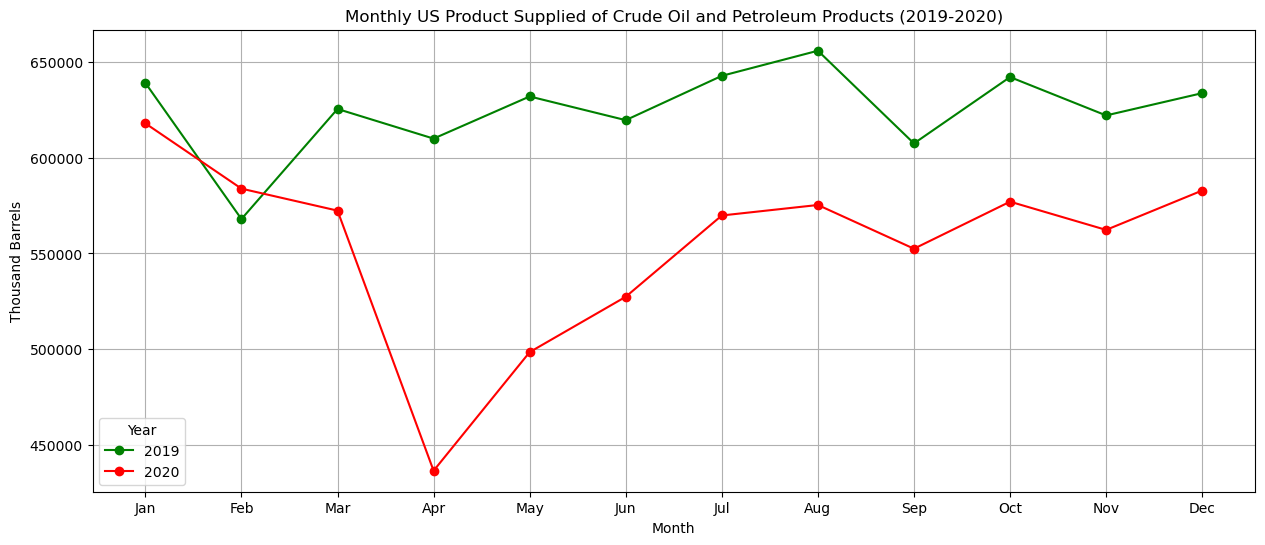

In [11]:
# Line plot for the US consumption of oil 2019-2020
plt.figure(figsize=(15,6))
plt.plot(oil_df.loc[2019], marker='o', color='green', label=str(2019))
plt.plot(oil_df.loc[2020], marker='o', color='red', label=str(2020))
plt.grid()
plt.title('Monthly US Product Supplied of Crude Oil and Petroleum Products (2019-2020)')
plt.xlabel('Month')
plt.ylabel('Thousand Barrels')
plt.legend(title="Year")

# Relationship Between Oil Consumption and Stock Prices
- The correlation coefficient between the total oil consumption and the stock prices of ExxonMobil, Chevron, ConocoPhillips, and Marathon Oil Corp indicate a moderate correlation. 
<br>
- On the otherhand, the near-zero slopes of each graph suggests no linear relationships. 
<br>
- Taking both into account, the moderate positive correlations suggest that while the linear regression lines are flat, there are still moderate tendencies for the variables to move together in a positive direction.


The correlation coefficient between total oil consumption and ExxonMobil's stock price is: 0.54937933178584


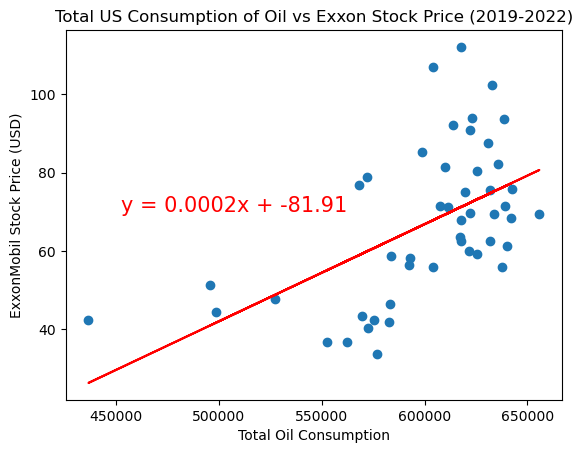

In [12]:
correlation = st.pearsonr(oil_df.values.flatten(), exxon_df.values.flatten())
print(f"The correlation coefficient between total oil consumption and ExxonMobil's stock price is: {correlation[0]}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(oil_df.values.flatten(), exxon_df.values.flatten())
regressvalues = slope * oil_df.values.flatten() + intercept
line_equation = f"y = {round(slope,4)}x + {round(intercept,2)}"
plt.scatter(oil_df.values.flatten(), exxon_df.values.flatten())
plt.plot(oil_df.values.flatten(), regressvalues, 'r-')
plt.annotate(line_equation, (452500,70), fontsize=15, color='r')
plt.title('Total US Consumption of Oil vs Exxon Stock Price (2019-2022)')
plt.ylabel('ExxonMobil Stock Price (USD)')
plt.xlabel('Total Oil Consumption')
plt.show()

The correlation coefficient between total oil consumption and Chevron's stock price is: 0.496264834272057


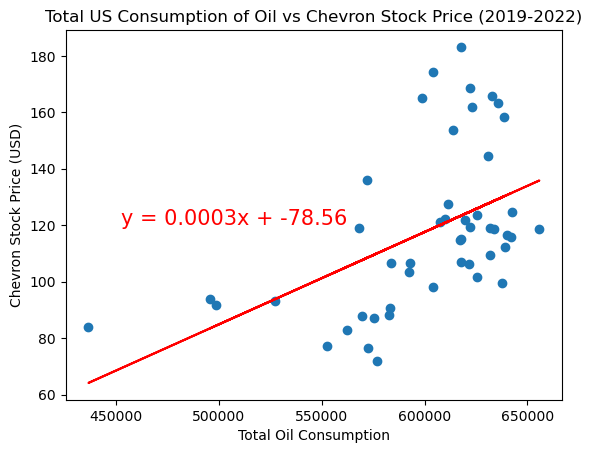

In [13]:
correlation = st.pearsonr(oil_df.values.flatten(), chevron_df.values.flatten())
print(f"The correlation coefficient between total oil consumption and Chevron's stock price is: {correlation[0]}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(oil_df.values.flatten(), chevron_df.values.flatten())
regressvalues = slope * oil_df.values.flatten() + intercept
line_equation = f"y = {round(slope,4)}x + {round(intercept,2)}"
plt.scatter(oil_df.values.flatten(), chevron_df.values.flatten())
plt.plot(oil_df.values.flatten(), regressvalues, 'r-')
plt.annotate(line_equation, (452500,120), fontsize=15, color='r')
plt.title('Total US Consumption of Oil vs Chevron Stock Price (2019-2022)')
plt.ylabel('Chevron Stock Price (USD)')
plt.xlabel('Total Oil Consumption')
plt.show()

The correlation coefficient between total oil consumption and ConocoPhillips' stock price is: 0.4655926567541677


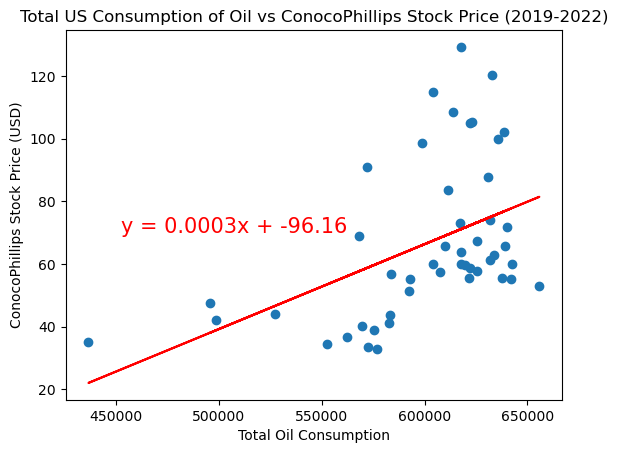

In [14]:
correlation = st.pearsonr(oil_df.values.flatten(), conoco_df.values.flatten())
print(f"The correlation coefficient between total oil consumption and ConocoPhillips' stock price is: {correlation[0]}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(oil_df.values.flatten(), conoco_df.values.flatten())
regressvalues = slope * oil_df.values.flatten() + intercept
line_equation = f"y = {round(slope,4)}x + {round(intercept,2)}"
plt.scatter(oil_df.values.flatten(), conoco_df.values.flatten())
plt.plot(oil_df.values.flatten(), regressvalues, 'r-')
plt.annotate(line_equation, (452500,70), fontsize=15, color='r')
plt.title('Total US Consumption of Oil vs ConocoPhillips Stock Price (2019-2022)')
plt.ylabel('ConocoPhillips Stock Price (USD)')
plt.xlabel('Total Oil Consumption')
plt.show()

The correlation coefficient between total oil consumption and Marathon Oil Corp stock price is: 0.5182665074893054


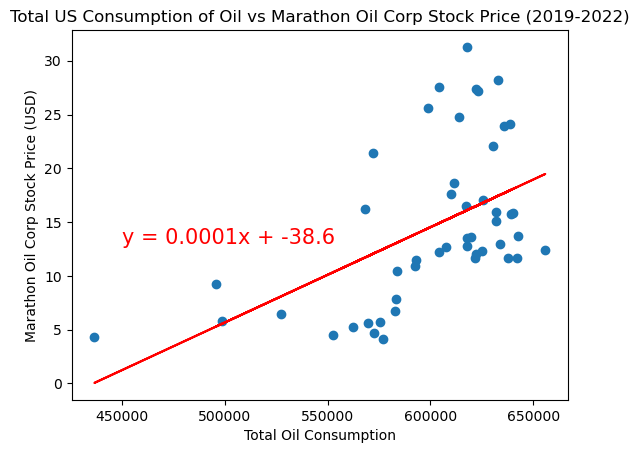

In [15]:
correlation = st.pearsonr(oil_df.values.flatten(), marathon_df.values.flatten())
print(f"The correlation coefficient between total oil consumption and Marathon Oil Corp stock price is: {correlation[0]}")
(slope, intercept, rvalue, pvalue, stderr) = linregress(oil_df.values.flatten(), marathon_df.values.flatten())
regressvalues = slope * oil_df.values.flatten() + intercept
line_equation = f"y = {round(slope,4)}x + {round(intercept,2)}"
plt.scatter(oil_df.values.flatten(), marathon_df.values.flatten())
plt.plot(oil_df.values.flatten(), regressvalues, 'r-')
plt.annotate(line_equation, (450000,13), fontsize=15, color='r')
plt.title('Total US Consumption of Oil vs Marathon Oil Corp Stock Price (2019-2022)')
plt.ylabel('Marathon Oil Corp Stock Price (USD)')
plt.xlabel('Total Oil Consumption')
plt.show()